In [199]:
include("astrobee_se3_script.jl")
using Plots


In [200]:
function solve_gusto(model, N, MAX_ITERATIONS_NB, verbose = true)
    
    Xp,Up = initialize_trajectory(model, N)
    X, U  = copy(Xp)  , copy(Up) 

    SCPproblem = GuSTOProblem(model, N, Xp, Up)

    x_dim, u_dim = model.x_dim, model.u_dim

    Delta0, omega0, omegamax, 
        epsilon, rho0, rho1, 
        beta_succ, beta_fail, gamma_fail, 
        convergence_threshold = get_initial_gusto_parameters(model)

    Delta = Delta0
    omega = omega0

    X_all, U_all = [], []
    push!(X_all, copy(X))
    push!(U_all, copy(U))

    B_success = false
    it = 0

    while it<MAX_ITERATIONS_NB && 
            !(it!=0 && it!=1 && it!=2 && it!=3 && B_success && 
                convergence_metric(model,X,U,Xp,Up)<convergence_threshold) &&
            omega<omegamax
        if verbose
            println("-----------")
            println("Iteration $it")
            println("metric=$(convergence_metric(model,X,U,Xp,Up))")
            println("-----------")
        end

        Xp = copy(X)
        Up = copy(U)

        model.f, model.A, model.B = compute_dynamics(model, Xp, Up)

        reset_problem(SCPproblem, model)
        set_parameters(SCPproblem, model, Xp, Up, omega, Delta)
        define_cost(SCPproblem, model)
        define_constraints(SCPproblem, model)

        JuMP.optimize!(SCPproblem.solver_model)    
        X_sol = JuMP.value.(SCPproblem.X)
        U_sol = JuMP.value.(SCPproblem.U)

        # -----------
        # GuSTO Logic
        if it > 3
            if is_in_trust_region(model, X_sol, U_sol, Xp, Up, Delta)
                rho = accuracy_ratio(SCPproblem, model, X_sol, U_sol, Xp, Up)

                if rho > rho1
                    if verbose
                        println("Reject solution.")
                    end
                    Delta = beta_fail * Delta
                    omega     = omega
                    B_success = false

                else
                    if verbose
                        println("Accept solution.")
                    end
                    X = copy(X_sol)
                    U = copy(U_sol)
                    B_success = true
                    if rho < rho0
                        Delta = min(beta_succ*Delta, Delta0)
                    else
                        Delta = Delta
                    end
                    if satisfies_state_inequality_constraints(SCPproblem, model, X_sol, U_sol, Xp, Up, Delta)
                        omega = omega0
                    else
                        if verbose
                            println("Solution does not satisfy state constraints, increasing omega.")
                        end
                        omega = gamma_fail * omega
                        B_success = false
                    end
                end
            else
                if verbose
                    println("Reject solution (Outside trust region)")
                end
                Delta = Delta
                omega     = gamma_fail * omega
                B_success = false
            end
    #         if convergence_metric(model,X,U,Xp,Up) <0.6
    #             println("Convergence metric very small. Decreasing Delta.")
    #             Delta = Delta0./(2^it)
    #         end

        else # always accept first solution
            X = copy(X_sol)
            U = copy(U_sol)
        end


        # -----------

        push!(X_all, copy(X))
        push!(U_all, copy(U))


        it += 1

        diff_with_prev = norm(copy(X) - copy(Xp), Inf)
        if verbose
            println("x(k) - x(k-1) = $diff_with_prev")
            println("Parameters:")
            println("omega=$omega")
            println("delta=$Delta")
        end
    end
    curr_conv_metric = convergence_metric(model,X,U,Xp,Up)
    if (B_success && 
                curr_conv_metric<convergence_threshold)
        if verbose
            println("Converged")
        end
        isConverged = true
    else
        if verbose
            println("Not converged. Metric =$curr_conv_metric")
        end
        isConverged = false
    end
    return isConverged, X_all, U_all
end

solve_gusto (generic function with 2 methods)

In [201]:
falses(5)

5-element BitArray{1}:
 false
 false
 false
 false
 false

In [202]:
a = [1;2;3]
b = [4;5;6]
c = [a,b]
c

2-element Array{Array{Int64,1},1}:
 [1, 2, 3]
 [4, 5, 6]

In [203]:
# function plot_env_solution(model, X_all)
#     N = length(X_all)

#     idx = [1,2]
#     local fig
#     fig = plot(framestyle = :box)
#     for iter = 1:length(X_all)
#         X = X_all[iter]
#         if iter ==1 
#             color = :darkblue
#             plot!(fig, X[1,:], X[2,:], line=(5, :dash); c=color, lab = "Initial guess")
#         elseif iter == length(X_all)
#             color = :green
#             plot!(fig, X[1,:], X[2,:], line=(5, :dash), c=color, lab = "Final solution")
#         else
#             color = :blue
#             plot!(fig, X[1,:], X[2,:]; c=color, lab = "")
#         end
        
#     end

#     for obs_i = 1:length(model.obstacles)
#         p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
#         plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
#     end
#     xlims!((model.x_min[1],model.x_max[1]))
#     ylims!((model.x_min[2],model.x_max[2]))
#     plot!(leg = true)
#     return fig
# end

In [214]:
function plot_solution(model, X_all)
    N = length(X_all)

    idx = [2,3]
    local fig
    fig = plot()
    for iter = 1:length(X_all)
        X = X_all[iter]
        plot!(fig, X[1,:], X[2,:]; c=:blue)
    end

    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius; color=:red, fig=fig)
    end
    
    for obs_i = 1:length(model.poly_obstacles)
        plot_polyObs_corners_2d(fig, model.poly_obstacles[obs_i]; dims=idx)
    end
    
    

    return fig
end

plot_solution (generic function with 1 method)

In [215]:
model.poly_obstacles[1]

PolygonalObstacle([0.0, 0.2, 0.2], 0.05, 0.05, 0.05, Array{Int64,1}[[0, -1, 0], [1, 0, 0], [0, 1, 0], [-1, 0, 0], [0, 0, 1], [0, 0, -1]], Array{Float64,1}[[0.05, 0.15, 0.25], [0.05, 0.25, 0.25], [-0.05, 0.25, 0.25], [-0.05, 0.15, 0.25], [0.05, 0.15, 0.15], [0.05, 0.25, 0.15], [-0.05, 0.25, 0.15], [-0.05, 0.15, 0.15]])

# Simple Case

In [216]:
include("astrobee_se3_script.jl")

N = 50
MAX_ITERATIONS_NB = 100

model = Astrobee()

model.x_init = [-0.25;0.4;0;  0;0;0;  0.;0.;0.; 1.;  0;0;0]
model.x_final = [0.7 ;-0.5;0;  0;0;0;  0.;0.;1.; 0.;  0;0;0]
model.tf_guess = 110.
model.convergence_threshold = 0.5
@show(model.obstacles)

isConverged, X_all, U_all = solve_gusto(model, N, MAX_ITERATIONS_NB, true)
@show size(X_all)
@show size(U_all)

model.obstacles = Any[Any[[0.4, -0.1, 0.0], 0.1]]
-----------
Iteration 0
metric=0.0
-----------
x(k) - x(k-1) = 0.22583021370705603
Parameters:
omega=1.0
delta=1000.0
-----------
Iteration 1
metric=21.16085204606289
-----------
x(k) - x(k-1) = 0.03277292481671068
Parameters:
omega=1.0
delta=1000.0
-----------
Iteration 2
metric=2.6891805706548584
-----------
x(k) - x(k-1) = 0.015901172098000238
Parameters:
omega=1.0
delta=1000.0
-----------
Iteration 3
metric=1.431567612442415
-----------
x(k) - x(k-1) = 0.007919859918275707
Parameters:
omega=1.0
delta=1000.0
-----------
Iteration 4
metric=0.7640704227644161
-----------
Accept solution.
x(k) - x(k-1) = 0.0015384145168428343
Parameters:
omega=1.0
delta=1000.0
Converged
size(X_all) = (6,)
size(U_all) = (6,)


(6,)

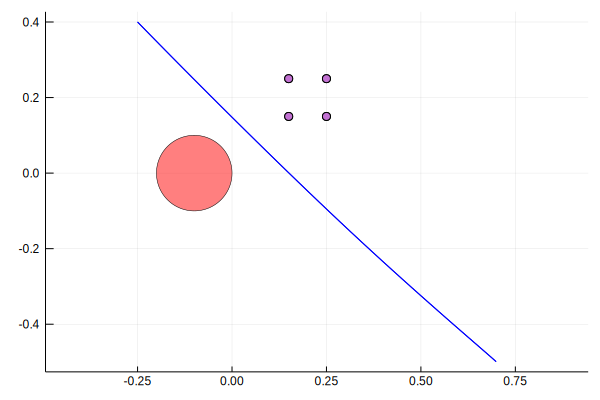

In [217]:
plot_solution(model, X_all[end-1:end,:])

distance = -0.08660254037844388


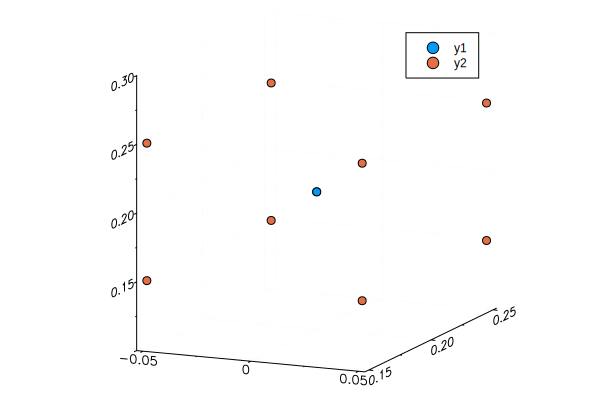

In [219]:
include("astrobee_se3_script.jl")
x = [0;0.2;0.2]
obs = model.poly_obstacles[1]
plot_distances(x, obs)